In [1]:
# Setting optimal number of threads for kmeans:
%env OMP_NUM_THREADS=1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
import pylab
import os
# allow us to see results under cell code
%matplotlib inline

env: OMP_NUM_THREADS=1


### Set working directory:

#### Check current working directory:

In [2]:
pwd

'C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering'

#### Setting desire working directory
(Provide path to the folder containing the .csv file from fiji)

In [3]:
os.chdir('C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering\\training_csv')

#### Check if provided path leads to desired directory:

In [4]:
os.getcwd()

'C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering\\training_csv'

### Setting filenames:

#### tracks_df - .csv file from fiji (or imageJ) containing information about generated tracks from TrackMate plugin
#### spots_df - .csv file from fiji (or imageJ) containing information about spots whithin every track
#### directory_name - name of the new directory that the workflow will create containing all output information and generated data frames in the form of .csv files

In [5]:
tracks_df = 'export_tracks_analiza_filtered.csv' 

spots_df = 'export_spots_analiza_filtered.csv'

# Please stick with convention of naming example: "TA_training_csv"
directory_name = 'TA_training_csv'

### Importing data from .csv to the data frame:

In [6]:
# Reading file with proper encoding form fiji:

raw_data = pd.read_csv(tracks_df, encoding = 'cp1250')
raw_data_spots = pd.read_csv(spots_df, encoding = 'cp1250')

# Fillling na values:
raw_data.fillna(0)

# Creating the df from interesting columns:
df_from_raw = raw_data[['LABEL', 'TRACK_ID','TRACK_MIN_SPEED', 'TRACK_MEDIAN_SPEED',
                          'TRACK_STD_SPEED', 'TOTAL_DISTANCE_TRAVELED',
                          'CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED',
                          'LINEARITY_OF_FORWARD_PROGRESSION',
                          'MEAN_DIRECTIONAL_CHANGE_RATE']].copy()

### Adjusting the data frame content: removing exces rows, converting types reseting index etc. 

In [7]:
# Droping first 3 row because of insuficient values:
df_dropped = df_from_raw.drop(df_from_raw.index[[0,1,2]])

# Setting the proper index order:
df_dropped = df_dropped.reset_index(level=None, drop=True)

# Setting proper data types of values:
# By use of to numeric it was able tooverlap the problem with commas.
df_w_floats = df_dropped.iloc[:, 2:10].apply(pd.to_numeric)
# We also adding the label column with the names of tracks changed to string
df_w_floats['LABEL'] = df_dropped['LABEL'].astype('string')
df_w_floats['TRACK_ID'] = df_dropped['TRACK_ID'].astype('int')
# df_w_floats.info()

# Creating sub-df without fiji labels:
df_no_Flabels = df_w_floats.copy()
df_no_Flabels = df_no_Flabels.drop(['LABEL', 'TRACK_ID'], axis = 1)
#df_no_Flabels.info()

### Making new directory for output provided by the workflow:

In [8]:
# getting the absolute path of the current working directory
current_dir = os.getcwd()

# creating path to new folder:
new_folder_path = os.path.abspath(os.path.join(current_dir, directory_name))

# Checking if the directory already exists
if not os.path.exists(new_folder_path): 
    # create the new folder
    os.mkdir(new_folder_path)
else:
    print(f"The directory {new_folder_path} already exists, using it instead.")
    
# set the new folder as the current working directory
os.chdir(new_folder_path)

# saving .csv to new folder:
df_w_floats.to_csv('df_w_floats.csv')
df_no_Flabels.to_csv('df_no_Flabes.csv')
raw_data_spots.to_csv('raw_spots_data.csv')

The directory C:\Users\Alek\Desktop\Github_commits\Trajectory_clustering\training_csv\TA_training_csv already exists, using it instead.


### Performing the spearman correlation of all features:

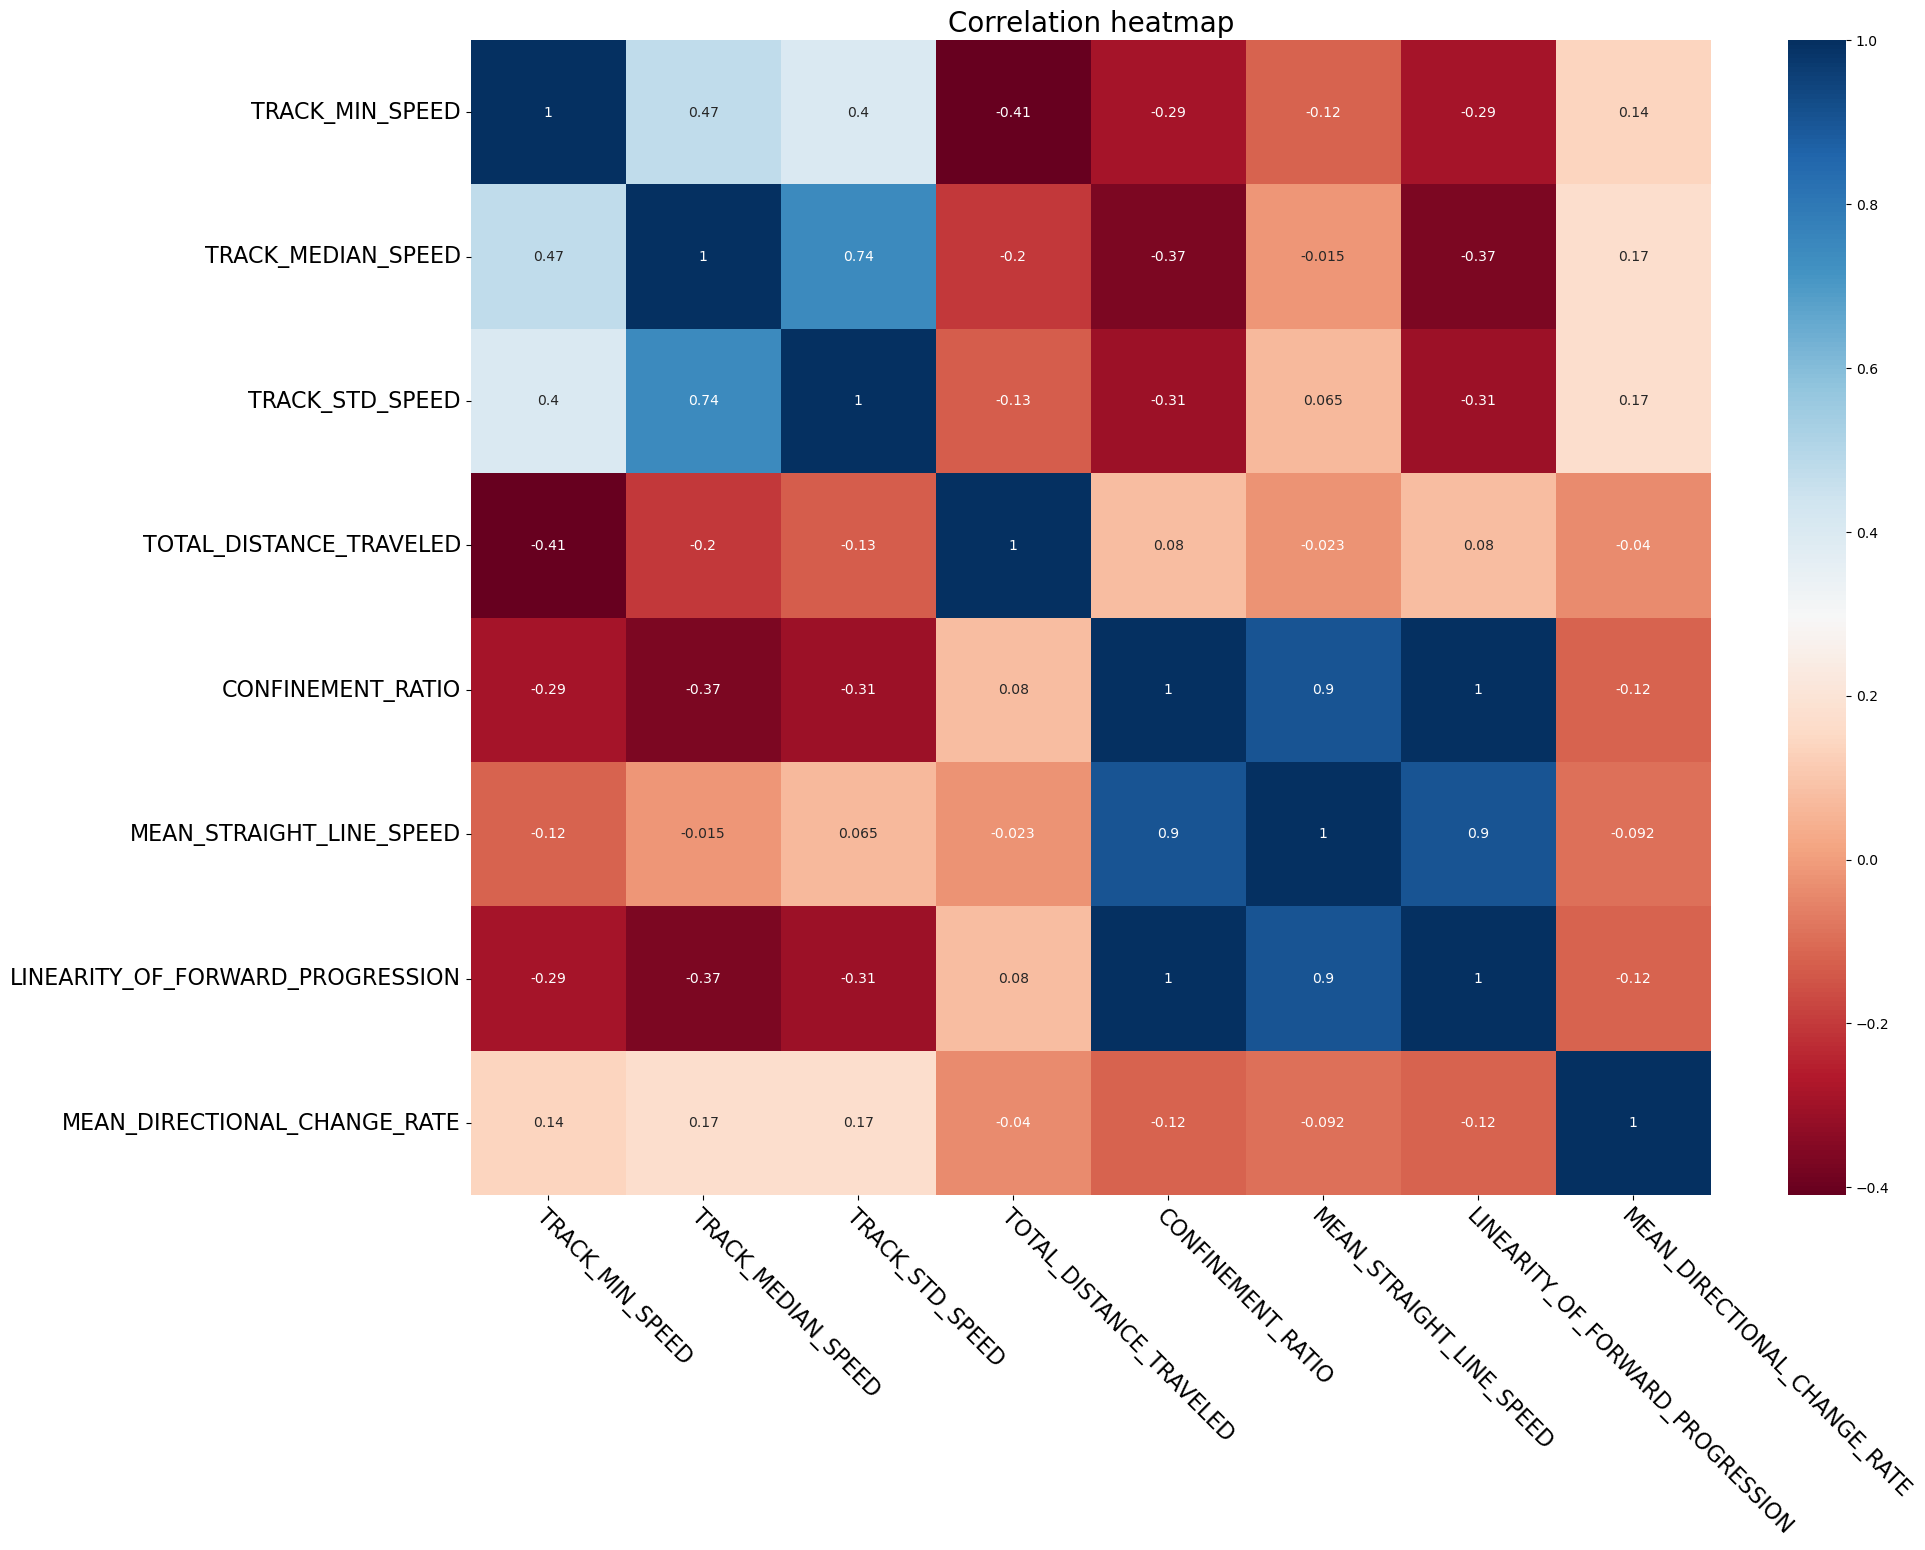

In [9]:
plt.figure(figsize=(20,15))
sns.heatmap(df_no_Flabels.corr(method='spearman'),
            annot=True, cmap='RdBu')
plt.title('Correlation heatmap', fontsize=20)
plt.yticks(rotation=0, fontsize = 16)
plt.xticks(rotation=-45, ha='left', rotation_mode='anchor', fontsize = 16)
plt.savefig("heatmap_spearman_out.jpg")
plt.show()

### Performing scaling of the data:


In [10]:
# Scaling data with robust scaler:

# Creating robustscaler object:
scaler_robust = RobustScaler()

# Separating the label from data frame:
label = df_w_floats['LABEL']

# Fit and transform the feature data:
scaled_features = scaler_robust.fit_transform(df_no_Flabels)

# Creating new data frame with the scaled features and the label column:
df_scaled = pd.DataFrame(scaled_features, columns=df_no_Flabels.columns)
df_scaled.insert(0, 'Label', label)

# saving the scaled data to csv
df_scaled.to_csv("tracks_df_scaled.csv")

### Prepering data to clustering:

From further testing the best performance in clustering for this analysis
was achived by reducing dimensionality of data set to 2 features and limiting cluster numbers to 2 (all concluded testing is provided in another script free to use) but for checking different purposes all data frame was scaled and the functions will allow changeing the features to perform different outputs. 

List of all possible features to use:
1. TRACK_MIN_SPEED
2. TRACK_MEDIAN_SPEED
3. TRACK_STD_SPEED
4. TOTAL_DISTANCE_TRAVELED
5. CONFINEMENT_RATIO
6. MEAN_STRAIGHT_LINE_SPEED
7. LINEARITY_OF_FORWARD_PROGRESSION
8. MEAN_DIRECTIONA_CHANGE_RATE

For my analysis best performance was achived by using the features 5 and 7. Please have in considaration that it is possible to change and use of other features may yield different outcome.

In [11]:
# Setting the data frame for K-Means and hierarchical clustering:
df_to_clustering = df_scaled[['CONFINEMENT_RATIO', 'MEAN_DIRECTIONAL_CHANGE_RATE']].copy()

#### Performing K-Means clustering on fixed parameters:

In [12]:
def perform_k_means_clustering(df):
    # Performing kmeans for provided dataframe:
    # kmeans_fp - means fixed parameters
    kmeans_fp = KMeans(n_clusters = 2, init='k-means++', n_init = 50,
                      max_iter = 10000, random_state = 1)
    kmeans_fp.fit_predict(df)
    
    # Getting the labels and centroids:
    labels = kmeans_fp.labels_
    centroids = kmeans_fp.cluster_centers_
    
    return labels, centroids 

In [13]:
def plot_kmeans(labels, data, centroids):
    
    """
    Plots the data points and centroids for KMeans clustering.

    Args:
    labels (numpy.ndarray): The cluster labels for each data point.
    data (pandas.DataFrame): The input data used for clustering.
    centroids (numpy.ndarray): The centroids of each cluster.

    Returns:
    None
    """
    try:
        # Check that labels are a numpy aray:
        if not isinstance(labels, np.ndarray):
            raise TypeError('Labels must be a numpy array.')
        
        # Check that the data is a pandas Data frame:
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the centroids are a numpy array:
        if not isinstance(centroids, np.ndarray):
            raise TypeError('Centroids must be a numpay array')
            
        # Check that the data and the centroids have two columns:
        if data.shape[1] != 2 or centroids.shape[1] != 2:
            raise ValueError("Data and centroids must have two columns")
        
        # Creating the scatter plot od the data points:
        plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c = labels, cmap = 'viridis')

        # Ploting the centroids as black stars:
        plt.scatter(centroids[:, 0], centroids[:, 1], c ='black', marker = '*',
                   s = 150)

        list_of_features = list(data.columns)
        # Set the axis:
        plt.title(f"KMeans clustering\n({list_of_features[0]} vs. {list_of_features[1]})")
        plt.xlabel(list_of_features[0])
        plt.ylabel(list_of_features[1])
        
        # Saving the plot:
        plt.savefig(f'kmeans_{list_of_features[0]}_vs_{list_of_features[1]}.png')

        # Showing the plot:
        plt.show()
    
    except Exception as e:
        print(f"An error occured: {e}")

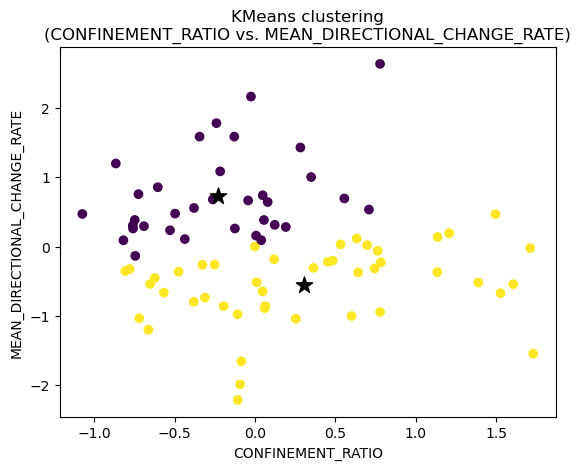

In [14]:
labels, centroids = perform_k_means_clustering(df_to_clustering)
plot_kmeans(labels, df_to_clustering, centroids)

#### Performing hierarchical clustering:

In [15]:
def hierarchical_clustering(df: pd.DataFrame):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the data and the centroids have two columns:
        if df.shape[1] != 2:
            raise ValueError("Data must have two columns")
        
        # Calculate the pairwise distance matrix
        dist_matrix = linkage(df.values, method='ward', metric='euclidean')
        
        # Plot the dendrogram:
        plt.title(f"Dendrogram of hierarchical clustering \n({df.columns[0]} vs. {df.columns[1]})")
        dendrogram(dist_matrix)
        plt.xlabel('Data points')
        plt.ylabel('Distance')
        
        # Fit the AgglomerativeClustering model to the data
        model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
        model.fit(df)
        
        # Get the cluster labels from the model
        clusters = model.labels_
        
        plt.savefig(f'dendrogram_{df.columns[0]}_vs_{df.columns[1]}.png')
        
        return dist_matrix, clusters
    
    except Exception as e:
        print(f"An error occurs: {e}")

In [16]:
def plot_hierarchical_data(df, labels):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the data and the centroids have two columns:
        if df.shape[1] != 2:
            raise ValueError("Data must have two columns")
            
        # Plot the clustered data
        plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c = labels, cmap = 'viridis')
        plt.xlabel(df.columns[0])
        plt.ylabel(df.columns[1])
        plt.title(f"Hierarchical Clustering \n({df.columns[0]} vs. {df.columns[1]})")
        plt.savefig(f"hierarchical_{df.columns[0]}_vs_{df.columns[1]}.png")
        plt.show()
        
    except Exception as e:
        print(f"An error occurs: {e}") 

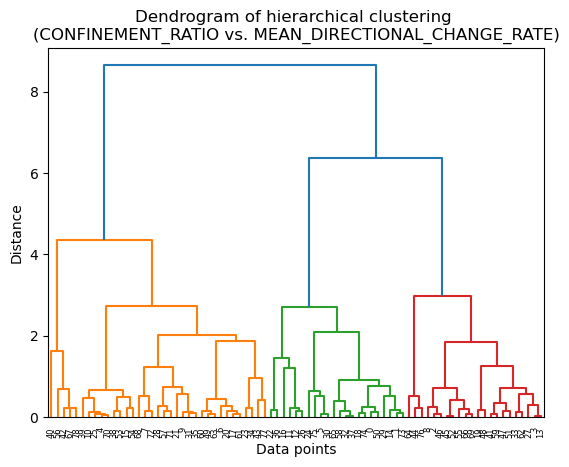

In [17]:
dist_matrix, hierarchical_labels = hierarchical_clustering(df_to_clustering)

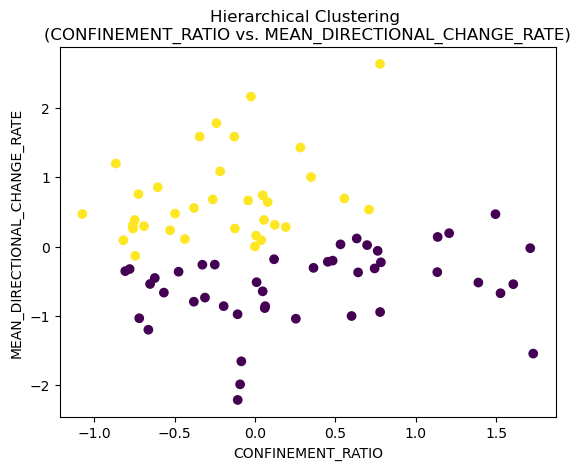

In [18]:
plot_hierarchical_data(df_to_clustering, hierarchical_labels)

#### Sorting the track_names by the clustering group:

##### Kmeans:

In [19]:
def get_kmeans_groups(df_w_track_names, cluster_labels):
    df = pd.DataFrame(df_w_track_names['Label'].copy())
    df['Cluster_labels'] = cluster_labels
    
    # Group the data by the cluster_labels column and get the list of track names
    # for each cluster:
    cluster_dict = df.groupby('Cluster_labels')['Label'].apply(list).to_dict()
    
    return cluster_dict

In [20]:
kmeans_dict = get_kmeans_groups(df_scaled, labels)

##### Hierarchical:

In [21]:
def get_hierarchical_groups(df_w_track_names, hierarchical_labels):
    df = pd.DataFrame(df_w_track_names['Label'].copy())
    df['Cluster_labels'] = hierarchical_labels
    
    # Group the data by the cluster_labels column and get the list of track names
    # for each cluster:
    cluster_dict = df.groupby('Cluster_labels')['Label'].apply(list).to_dict()
    
    return cluster_dict

In [22]:
hierarchical_dict = get_hierarchical_groups(df_scaled, hierarchical_labels)

#### Creating data frames with columns taken to the clustring and their label values:

In [23]:
# For Kmeans:
df_after_kmeans = pd.DataFrame(df_to_clustering.copy())
df_after_kmeans['Cluster_labels'] = labels

# For hierarchical:
df_after_hierarchical = pd.DataFrame(df_to_clustering.copy())
df_after_hierarchical['Cluster_labels'] = hierarchical_labels

### Comparison the groups after clustering:

#### Performing pie plot of the clusters after kmeans

In [24]:
from collections import Counter

def plot_clusters_pie(cluster_dict: dict, algorithm_name: str):
    try:
        # Count the number of elements in each cluster:
        cluster_counts = Counter({k: len(v) for k, v in cluster_dict.items()})
        
        # Create a pie plot:
        labels = [f'Clusters {k}' for k in cluster_counts.keys()]
        sizes = list(cluster_counts.values())
        
        # Setting to show the number of tracks in each group:
        def autopct_func(pct):
            total = sum(cluster_counts.values())
            count = int(round(pct*total/100))
            return f'{pct:.1f}%\n({count})'
        
        plt.pie(sizes, labels = labels, autopct = autopct_func)
        plt.axis('equal')
        plt.title(f'Group distribution after {algorithm_name}')
        plt.savefig(f'pie_plot_of_{algorithm_name}_groups.png')
        plt.show()
        
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        plt.close()

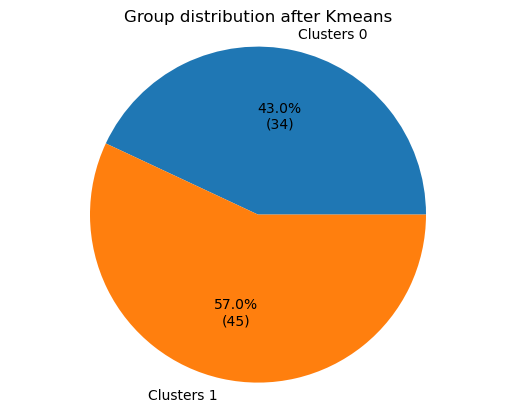

In [25]:
plot_clusters_pie(kmeans_dict, 'Kmeans')

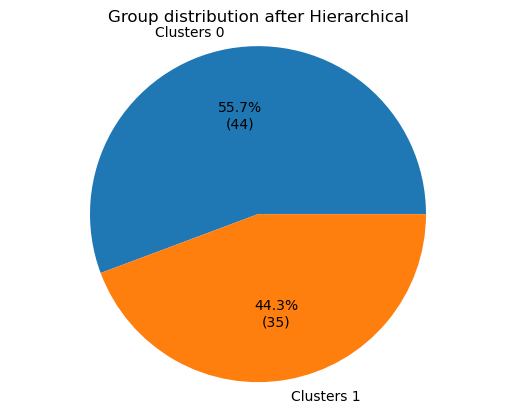

In [26]:
plot_clusters_pie(hierarchical_dict, 'Hierarchical')

#### Comparing the cluster groups:

In [27]:
def compare_dicts(dict1, dict2):
    try:
        # get the common keys from both dictionaries
        common_keys = set(dict1.keys()) & set(dict2.keys())

        # compare the values of each common key
        for key in common_keys:
            if dict1[key] != dict2[key]:
                # find the differences between the two lists
                set1 = set(dict1[key])
                set2 = set(dict2[key])
                differences = set1.symmetric_difference(set2)

                # print the key and the differing values
                print(f"Differences in group {key}:")
                for val in differences:
                    if val in set1 and val not in set2:
                        print(f"Value '{val}' only in first dictionary")
                    elif val in set2 and val not in set1:
                        print(f"Value '{val}' only in second dictionary")
            else:
                print(f"Group {key} is identical in both dictionaries")

        # print the keys that are only present in one dictionary
        keys_only_in_dict1 = set(dict1.keys()) - common_keys
        keys_only_in_dict2 = set(dict2.keys()) - common_keys
        if keys_only_in_dict1:
            print(f"The following groups are only in the first dictionary: {keys_only_in_dict1}")
        if keys_only_in_dict2:
            print(f"The following groups are only in the second dictionary: {keys_only_in_dict2}")
    except Exception as e:
        print(f"An errot occured: {e}")

In [28]:
# Calling compare dicts to chcek the differences in the cluster groups:
compare_dicts(kmeans_dict, hierarchical_dict)

Differences in group 0:
Value 'Track_0' only in second dictionary
Value 'Track_28' only in second dictionary
Value 'Track_906' only in first dictionary
Value 'Track_57' only in first dictionary
Value 'Track_79' only in second dictionary
Value 'Track_126' only in first dictionary
Value 'Track_275' only in second dictionary
Value 'Track_625' only in first dictionary
Value 'Track_49' only in second dictionary
Value 'Track_357' only in first dictionary
Value 'Track_984' only in second dictionary
Value 'Track_261' only in second dictionary
Value 'Track_731' only in second dictionary
Value 'Track_33' only in second dictionary
Value 'Track_47' only in second dictionary
Value 'Track_27' only in first dictionary
Value 'Track_359' only in second dictionary
Value 'Track_53' only in first dictionary
Value 'Track_75' only in first dictionary
Value 'Track_1355' only in first dictionary
Value 'Track_965' only in first dictionary
Value 'Track_55' only in second dictionary
Value 'Track_1327' only in fi

#### Comparing features accros the clusters:

In [29]:
def plot_boxplot_sns(df, algorithm_name: str):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')

        # Getting the names of the features to avoid hard coding the names:
        feature_names = list(df.columns)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        data_0 = df[df[str(feature_names[2])] == 0][[str(feature_names[0]), str(feature_names[1])]]
        data_1 = df[df[str(feature_names[2])] == 1][[str(feature_names[0]), str(feature_names[1])]]

        # Calculating the standard deviation for whiskers:
        std_0 = data_0.std().values
        std_1 = data_1.std().values

        axs[0] = sns.boxplot(data=[data_0[str(feature_names[0])], data_1[str(feature_names[0])]], 
                             ax=axs[0], notch=True, whis=(std_0[0], std_0[0]) )
        axs[1] = sns.boxplot(data=[data_0[str(feature_names[1])], data_1[str(feature_names[1])]], 
                             ax=axs[1], notch=True, whis=(std_1[0], std_1[0]) )

        axs[0].set_title(f"{feature_names[0]} by Cluster")
        axs[1].set_title(f"{feature_names[1]} by Cluster")
        plt.savefig(f'{algorithm_name}_feature_boxplot.png')
        
        plt.show()
        
    except Exception as e:
        print(f"An error occured: {e}")

When using the parameter whis with a tuple of the same value for the upper and lower whiskers, such as whis=(std_0[0], std_0[0]), the upper whisker may not be visible if there are any outliers above the upper whisker. This is because the upper whisker is drawn to the maximum data point within the whisker length, which is determined by the range of the data and the specified whis value. However, if there are any data points beyond the upper whisker length, they will be plotted as outliers, and the upper whisker will not be visible.

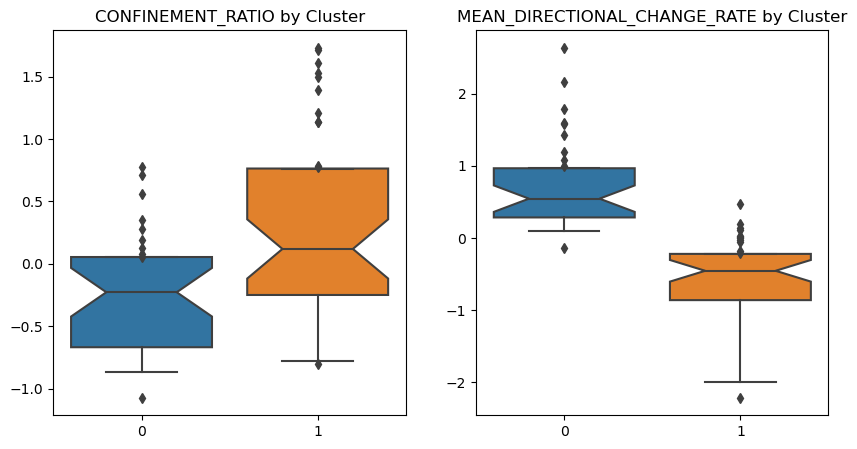

In [30]:
plot_boxplot_sns(df_after_kmeans, 'kmeans')

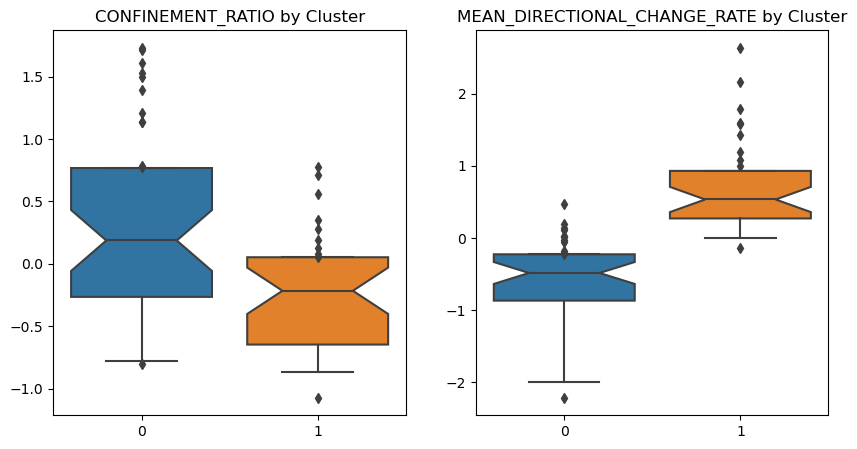

In [31]:
plot_boxplot_sns(df_after_hierarchical, 'hierarchical')

### Preapring spots data frame from raw:

In [32]:
# Now there should be added the parsing of the spots data frame to
# aquire the gruped df of the tracks with all the points accros
# it's movement.

In [33]:
# Creating data frame with the track label, start_pos, end_pos, track_id
df_track_start_end_info = raw_data[['LABEL', 'TRACK_ID', 
                                'TRACK_START', 'TRACK_STOP']].copy()

# Droping unnecessary rows:
df_track_start_end_info.drop(df_track_start_end_info.index[[0,1,2]],
                              inplace = True)

# Reseting index of the whole data frame:
df_track_start_end_info.reset_index(level = None, drop=True, inplace = True)

# Setting proper types of the cells:
df_start_end_tracks = df_track_start_end_info.iloc[:, 1:4].apply(pd.to_numeric)
df_start_end_tracks['Label'] = df_track_start_end_info['LABEL'].astype('string')

# Performing operations on the .csv file with the information about spots:
df_only_spots = raw_data_spots[['TRACK_ID', 'POSITION_X', 'POSITION_Y',
                                'POSITION_T', 'FRAME']].copy()

# Droping unnecesary rows:
df_only_spots.drop(df_only_spots.index[[0,1,2]], inplace=True)

# Reseting the index of the whole data frame:
df_only_spots.reset_index(level=None, drop=True, inplace = True)

# Setting proper types:
df_all_spots = df_only_spots.iloc[:, 0:5].apply(pd.to_numeric)

In [34]:
# Joining two tables on track_id:
df_spots_merged = pd.merge(df_start_end_tracks, df_all_spots, how = 'inner',
                          on='TRACK_ID',
                          suffixes=['','_'])[['Label', 'TRACK_ID', 'TRACK_START',
                                             'TRACK_STOP', 'FRAME', 'POSITION_X',
                                             'POSITION_Y', 'POSITION_T']]

In [35]:
# Sorting merged data frame by the time position for each track:
gruped_tracks = df_spots_merged.sort_values(['TRACK_ID','POSITION_T'],ascending=True).groupby('TRACK_ID')
sorted_tracks_df = gruped_tracks.apply(lambda x: x)
sorted_tracks_df.head()

C:\Users\Alek\AppData\Local\Temp\ipykernel_11280\2984349333.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sorted_tracks_df = gruped_tracks.apply(lambda x: x)


,Label,TRACK_ID,TRACK_START,TRACK_STOP,FRAME,POSITION_X,POSITION_Y,POSITION_T
75,Track_0,0,0.0,202.0,0,67.146850,85.546652,0.0
149,Track_0,0,0.0,202.0,1,67.008878,85.449081,1.0
14,Track_0,0,0.0,202.0,2,66.915325,85.566201,2.0
98,Track_0,0,0.0,202.0,3,66.751480,85.136118,3.0
167,Track_0,0,0.0,202.0,4,66.827460,85.078060,4.0


In [36]:
# After this there should be added function to generating points in straight
# line from the start and finish x,y coords of the tracks

In [37]:
# Making dictionary out of the sorted spots data frame:
def track_positions_dict(spots_df):
    try:
        # checking if provided variable is a data fream
        if not isinstance(spots_df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
        
        # Grouping data from data frame by the track_name:
        grouped_data = spots_df.groupby('Label')
        
        # creating the dictionary with the track name and all its pos_x, 
        # pos_y as tuples:
        result_dict = {name: list(zip(group['POSITION_X'], group['POSITION_Y'])) for name, group in grouped_data}
        
        # returning the result:
        return result_dict
    except Exception as e:
        print(f'An error occurs: {e}')

In [38]:
# Calling function to generate the dictionary of position in track:
track_positions_dict = track_positions_dict(sorted_tracks_df)

# Testing the generated dictionary:
# track_positions_dict['Track_0']

In [39]:
# Function generating coordinates in straight line to the start, end
# coordinates of a track:
def generating_points_in_line(x_A, y_A, x_B, y_B, n_samples):
    try:
        # Chceking if provided coordinates are in vertical line:
        if x_A == x_B: # vertical line
            y_values = [y_A + i*(y_B-y_A)/(n_samples-1) for i in range(n_samples)]
            x_values = [x_A] * n_samples
        
        else: # non-vertical line
            x_values = [x_A + i*(x_B-x_A)/(n_samples-1) for i in range(n_samples)]
            y_values = [y_A + i*(y_B-y_A)/(n_samples-1) for i in range(n_samples)]

        # make sure first and last points are (x_A, y_A) and (x_B, y_B) respectively
        x_values[0] = x_A
        y_values[0] = y_A
        x_values[-1] = x_B
        y_values[-1] = y_B

        # create a list of tuples representing the generated points
        points = [(x_values[i], y_values[i]) for i in range(n_samples)]

        return points
    except Exception as e:
        print(f'An error occurs: {e}')

In [40]:
def generate_straight_line_for_all_tracks(tracks_dict: dict, df_start_end_tracks):
    try:
        # Setting the dictionary to stroe output of positions
        # and the name of track:
        track_in_line_pos_dict = {}
        
        # Iterate throught the tracks_dict keys:
        for name in tracks_dict.keys():
            # Setting the name variable:
            track_name = str(name)
            
            # Cacluclating the number of frames from start to finish of movement:
            df = df_start_end_tracks.copy()
            df = df.set_index('Label')
            start_frame = df.loc[track_name, 'TRACK_START'].astype('int32')
            end_frame = df.loc[track_name, 'TRACK_STOP'].astype('int32')
            
            # There have to be +1 addition in case to get all occurances 
            # of moving from first frame to last for example if track
            # starts moving in 0 frame and end in 200 frame function need
            # to generate 201 positions to cover all movemnt frames:
            move_frames = (end_frame-start_frame) + 1
            
            # Getting start and end coordinates:
            list_of_coords = tracks_dict[track_name]
            start_coords = list_of_coords[0]
            end_coords = list_of_coords[-1]
            
            # setting the start position variables:
            start_x, start_y = start_coords
            
            # setting the end positions:
            end_x, end_y = end_coords
            
            # Calling function to generate points in line to return each positions:
            tracks_move_in_line_list = generating_points_in_line(start_x, start_y, end_x, end_y, move_frames)
            
            # Adding all the lists to dict with the proper track names:
            track_in_line_pos_dict[str(name)]= tracks_move_in_line_list
            
        return track_in_line_pos_dict
    
    except Exception as e:
        print(f'An error occurs: {e}')

In [41]:
# Calling function to generate the line positions for all tracks:
straight_tracks_dict = generate_straight_line_for_all_tracks(track_positions_dict, df_start_end_tracks)

# Test checking of dictionary:
#straight_tracks_dict['Track_0']

### Functions calculating distances:

#### Function calculating total euclidean distance:

In simpler terms function will compare the each coordinate x,y points with the generated linear cunterpart generated inprevious steps. This functions need to get the trajectories of the same length. In the proces it calculates the euclidean distance with each point and add them together. Overall return the total euclidean distance. Total distance is the sum of all the distances calculated during operation among the points of both tracks. 

If the two compared trajectories are the same then total distance returned should be zero. Overall distance obtained describes the differences in realtion to the trajectory, which is a straight line with the same start nad end points as the analyzed path. 

In [42]:
import math
# Function performing euclidean distance:
def euclidean_distance(p1, p2):
    '''
    Calculate the Euclidean distance between two points.
    '''
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Function performing total euclidean distance calculations:
def total_euclidean_distance(first_list_of_points, second_list_of_points):
    """
    Calculate the total Euclidean distance between a series of points.
    """
    if len(first_list_of_points) != len(second_list_of_points):
        raise ValueError('The two series of points have different lengths')
    else:
        distance = 0
        for i in range(len(first_list_of_points)):
            distance += euclidean_distance(first_list_of_points[i], second_list_of_points[i])
        
    return distance

# Function performing extracting lists of series of points and calling 
# functions calculating distance, returning the dictionari with names
# as keys and values of distance as the value:
def euclidean_comparison_original_straight(tracks_dict: dict, straight_tracks_dict: dict):
    # Check if the provided dictionaries have the same names of track to avoid false comparision:
    try: 
        list_of_track_names = list(tracks_dict.keys())
        
        list_of_straight_tracks_names = list(straight_tracks_dict.keys())
    except Exception as e:
        print(f'An error occurred: {e}')
    
    # Checking if the lists have the same content:
    try:
        # Dictionary for return the values of distance and track_names:
        result_dict = {}
        
        set1 = set(list_of_track_names)
        set2 = set(list_of_straight_tracks_names)
        if set1 == set2:
            for name in set1:
                track_series = tracks_dict[name]
                straight_line_series = straight_tracks_dict[name]
                total_distance = total_euclidean_distance(track_series, straight_line_series)
                
                print(f'Total euclidean distance of {name} track and \nits linear generation: {total_distance}')
                result_dict[str(name)] = float(total_distance)
                
        else:
            print("Provided sets differ which means there could be error in generating points.")
        
        return result_dict
    except Exception as e:
        print(f'An error occurred: {e}')

In [43]:
euclidean_comp_dict = euclidean_comparison_original_straight(track_positions_dict,
                                           straight_tracks_dict)
# Test checking:
# euclidean_comp_dict['Track_0']

Total euclidean distance of Track_0 track and 
its linear generation: 193.11983465040896
Total euclidean distance of Track_28 track and 
its linear generation: 86.86051113417096
Total euclidean distance of Track_906 track and 
its linear generation: 112.54703482567588
Total euclidean distance of Track_57 track and 
its linear generation: 45.46566824948038
Total euclidean distance of Track_79 track and 
its linear generation: 392.726907168235
Total euclidean distance of Track_126 track and 
its linear generation: 115.13088143253965
Total euclidean distance of Track_275 track and 
its linear generation: 306.7344024302671
Total euclidean distance of Track_625 track and 
its linear generation: 140.7996681056274
Total euclidean distance of Track_49 track and 
its linear generation: 41.226716187950814
Total euclidean distance of Track_357 track and 
its linear generation: 46.910000307788884
Total euclidean distance of Track_984 track and 
its linear generation: 51.957209054083734
Total eucli

#### Function performing Dynaming Time Warping:

Algorithm DTW finds optimal aligment beetwen two provided trajectories by matchin each point of one trajectory to the corresponding point of the other. 

The output of function is the distance between trajectories and optimal aligment between two trajectories. 

In [44]:
from typing import Dict, List, Tuple
from dtw import *
from scipy.spatial.distance import euclidean

def dtw_comparison_original_straight(tracks_dict: Dict[str, List[Tuple[float, float]]], straight_tracks_dict: Dict[str, List[Tuple[float, float]]]) -> Dict[str, float]:
    '''
    Function calculates the distance with the DTW (Dinamic Time Warping) algorithm.
    Distance is calculated from provided dictionaries containing the track name, list of 
    coordinates in the from of tuple for both original and lineary generated trajectories. 
    
    Args:
    - tracks_dict (dict): Dictionary with track name and the list of coordinates from start to finish of movement in form of tuple
    - straight_tracks_dict (dict): Same as tracks_dict but contains generated trajectories which are linear and have the same number of 
        points as original trajectories
        
    Returns:
    - resutl_dict (dict): Dictionary containing the values of the distance calcualted by DTW, which describes the distance of original trajectory
        to their linear cunterpart generated in previous steps. 
    '''
    try:
        # Setting dict for the results
        result_dict = {}
        
        # Iterating throught the dict_keys both dicts contains the same 
        # keys in it:
        for name in tracks_dict.keys():
            if name in straight_tracks_dict.keys():
                x = tracks_dict[name]
                y = straight_tracks_dict[name]
                ds = dtw(x, y, dist_method='euclidean')
                
                # Returnig of the DTW result distance for each trajectory
                # to their linear cunterpart
                result_dict[name] = ds.distance
            else:
                print(f"Warning: no straight track found for {name}")

        return result_dict
    
    except Exception as e:
        print(f'An error occurs: {e}')

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [45]:
dtw_dict = dtw_comparison_original_straight(track_positions_dict,
                                            straight_tracks_dict)
# Testing the output:
# dtw_dict

#### Comparing the values of distances to the linear trajectory:

In [46]:
# Comparing distances into single data frame:
df_distances_to_linear = pd.DataFrame(list(euclidean_comp_dict.values()),
                                      index=euclidean_comp_dict.keys(),
                                      columns=['Euclidean_distance'])

# Creating new series from dtw_dictionary:
dtw_distance = pd.Series(dtw_dict, name = 'DTW_distance')

# Adding new column
df_distances_to_linear = pd.concat([df_distances_to_linear, dtw_distance], axis = 1)

# Saving data frame to the .csv file
df_distances_to_linear.to_csv('distances_after_clustering.csv')

In [47]:
def assign_clusters_to_df(df, cluster_dict, column_name):
    """
    Assigns binary values to each track based on their cluster membership
    as given in the cluster_dict and adds a new column to the DataFrame
    
    Args:
    df (pd.DataFrame): The DataFrame to which the cluster labels are to be added
    cluster_dict (dict): A dictionary containing the cluster membership of each track
    column_name (str): The name of the new column to be added
    
    Returns:
    pd.DataFrame: The updated DataFrame with a new column added containing the cluster labels
    """
    # Create a new column named kmeans_clusters filled with 0
    df[column_name] = 0
    
    # Iterate through each cluster in the dictionary
    for k, v in cluster_dict.items():
        # Get the index of the tracks in the current cluster
        cluster_idx = df.index.isin(v)
        # Assign 1 to the kmeans_clusters column for tracks in the current cluster
        df.loc[cluster_idx, column_name] = k
        
    return df

In [48]:
# Calling with the kmeans_dict:
df_distances_to_linear = assign_clusters_to_df(df_distances_to_linear,
                                               kmeans_dict,
                                               'kmeans_clusters')
# Calling with the hierarchical_dict:
df_distances_to_linear = assign_clusters_to_df(df_distances_to_linear,
                                               hierarchical_dict,
                                               'hierarchical_clusters')

# Saving data frame to the .csv file
df_distances_to_linear.to_csv('distances_after_clustering_assigned.csv')

In [49]:
df_distances_to_linear

,Euclidean_distance,DTW_distance,kmeans_clusters,hierarchical_clusters
Track_0,193.119835,155.720481,1,0
Track_28,86.860511,88.451466,1,0
Track_906,112.547035,117.217505,0,1
Track_57,45.465668,47.801493,0,1
Track_79,392.726907,216.325442,1,0
...,...,...,...,...
Track_50,99.852000,79.035393,1,1
Track_755,334.844985,182.338828,0,1
Track_880,74.459617,65.205873,1,0
Track_161,41.121338,47.382448,1,0


#### Comapring distances among the groups from clustering:

In [70]:
def cluster_distance_stats(cluster_dict: dict, df: pd.DataFrame):
    """
    Calculates the mean, median, and standard deviation of distance values for each cluster
    in the provided dictionary of cluster labels and track names

    Args:
    - cluster_dict (dict): Dictionary with cluster labels as keys and lists of track names as values
    - df (pandas.DataFrame): DataFrame with distance values for each track

    Returns:
    - stats_dict (dict): Dictionary with cluster labels as keys and a tuple of mean, median, and
                         standard deviation of distance values for each cluster as values
    """
    try:
        # Check if the 'Euclidean_distance' and 'DTW_distance' columns are present in the data frame
        if 'Euclidean_distance' not in df.columns or 'DTW_distance' not in df.columns:
            raise ValueError("Data frame does not have the required distance columns.")

        stats_dict = {}

        for cluster_label, track_list in cluster_dict.items():
            # Select the rows of the DataFrame corresponding to the tracks in the current cluster
            cluster_df = df.loc[track_list]

            # Calculate the mean, median, and standard deviation of the distance values for the current cluster
            euclidean_mean = np.mean(cluster_df['Euclidean_distance'])
            euclidean_median = np.median(cluster_df['Euclidean_distance'])
            euclidean_std = np.std(cluster_df['Euclidean_distance'])

            dtw_mean = np.mean(cluster_df['DTW_distance'])
            dtw_median = np.median(cluster_df['DTW_distance'])
            dtw_std = np.std(cluster_df['DTW_distance'])

            # Add the mean, median, and standard deviation to the dictionary for the current cluster
            stats_dict[cluster_label] = ((euclidean_mean, euclidean_median, euclidean_std),
                                         (dtw_mean, dtw_median, dtw_std))

        return stats_dict
    
    except Eception as e:
        print(f'An error occurs: {e}')

In [88]:
# Calling the function to get the statistics of the distances for each cluster:
kmeans_groups_stats = cluster_distance_stats(kmeans_dict,
                                             df_distances_to_linear)
# Checking the content of dictionary:
# kmeans_groups_stats

# Performing the same operation for the hierarchical cluster dictionary:
hierarchical_groups_stats = cluster_distance_stats(hierarchical_dict,
                                                  df_distances_to_linear)

In [66]:
def group_tracks_by_cluster(df: pd.DataFrame, cluster_column: str):
    """
    Groups the tracks in the DataFrame by the cluster label in the specified column.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the tracks and their cluster labels.
        cluster_column (str): The name of the column containing the cluster labels.
    
    Returns:
        dict: A dictionary where the keys are cluster labels and the values are lists of tuples
              containing the track name and the distance values for each track in the cluster.
    """
    try:
        # Create an empty dictionary to store the clusters
        clusters = {}

        # Iterate through each row in the DataFrame
        for index, row in df.iterrows():
            # Get the cluster label for the current track
            cluster_label = row[cluster_column]

            # Check if the current cluster label already exists in the dictionary
            if cluster_label not in clusters:
                # If it doesn't exist, create a new list for the current cluster label
                clusters[cluster_label] = []

            # Add a tuple containing the track name and the distance values to the list for the current cluster label
            clusters[int(cluster_label)].append((index, row['Euclidean_distance'], row['DTW_distance']))

        return clusters 
    
    except Exception as e:
        print(f'An error occurs: {e}')

In [67]:
# Calling of the function to get the distances dictionaries:
kmeans_groups_distances = group_tracks_by_cluster(df_distances_to_linear, 
                                                 'kmeans_clusters')

# Calling same function to get hierarchical groups:
hierarchical_groups_distances = group_tracks_by_cluster(df_distances_to_linear,
                                                       'hierarchical_clusters')

In [89]:
kmeans_groups_stats

{0: ((176.75447985959963, 113.83895812910777, 176.79593797016133),
  (158.88734186315577, 107.22377529256462, 152.86148603129416)),
 1: ((238.65153217439126, 156.68455998593876, 213.22112781785026),
  (228.3988701890969, 144.62363229064812, 250.15979629887354))}

In [50]:
df_start_end_tracks

,TRACK_ID,TRACK_START,TRACK_STOP,Label
0,0,0.0,202.0,Track_0
1,2,0.0,328.0,Track_2
2,7,0.0,74.0,Track_7
3,9,0.0,169.0,Track_9
4,10,0.0,198.0,Track_10
...,...,...,...,...
74,1019,252.0,419.0,Track_1019
75,1187,306.0,435.0,Track_1187
76,1324,351.0,499.0,Track_1324
77,1327,352.0,499.0,Track_1327


In [51]:
df_spots_merged

,Label,TRACK_ID,TRACK_START,TRACK_STOP,FRAME,POSITION_X,POSITION_Y,POSITION_T
0,Track_0,0,0.0,202.0,148,65.606465,84.493926,148.0
1,Track_0,0,0.0,202.0,53,66.725150,85.414498,53.0
2,Track_0,0,0.0,202.0,187,65.282319,84.288380,187.0
3,Track_0,0,0.0,202.0,42,66.731259,85.048971,42.0
4,Track_0,0,0.0,202.0,129,66.535793,85.466081,129.0
...,...,...,...,...,...,...,...,...
18493,Track_1355,1355,362.0,489.0,386,135.112239,72.324189,386.0
18494,Track_1355,1355,362.0,489.0,398,135.038800,72.204136,398.0
18495,Track_1355,1355,362.0,489.0,383,134.617692,71.736037,383.0
18496,Track_1355,1355,362.0,489.0,401,134.895214,71.898385,401.0


In [52]:
df_spots_merged.to_csv('test_merged.csv')

In [53]:
sorted_tracks_df.to_csv('test_sorted.csv')

In [54]:
sorted_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18498 entries, 75 to 18436
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        18498 non-null  string 
 1   TRACK_ID     18498 non-null  int64  
 2   TRACK_START  18498 non-null  float64
 3   TRACK_STOP   18498 non-null  float64
 4   FRAME        18498 non-null  int64  
 5   POSITION_X   18498 non-null  float64
 6   POSITION_Y   18498 non-null  float64
 7   POSITION_T   18498 non-null  float64
dtypes: float64(5), int64(2), string(1)
memory usage: 1.3 MB


In [55]:
kmeans_dict

{0: ['Track_10',
  'Track_24',
  'Track_27',
  'Track_29',
  'Track_30',
  'Track_38',
  'Track_44',
  'Track_51',
  'Track_53',
  'Track_57',
  'Track_66',
  'Track_72',
  'Track_75',
  'Track_76',
  'Track_80',
  'Track_82',
  'Track_85',
  'Track_126',
  'Track_148',
  'Track_229',
  'Track_301',
  'Track_357',
  'Track_487',
  'Track_498',
  'Track_576',
  'Track_625',
  'Track_755',
  'Track_889',
  'Track_906',
  'Track_957',
  'Track_965',
  'Track_981',
  'Track_1327',
  'Track_1355'],
 1: ['Track_0',
  'Track_2',
  'Track_7',
  'Track_9',
  'Track_15',
  'Track_28',
  'Track_33',
  'Track_35',
  'Track_36',
  'Track_37',
  'Track_42',
  'Track_47',
  'Track_49',
  'Track_50',
  'Track_52',
  'Track_55',
  'Track_58',
  'Track_63',
  'Track_67',
  'Track_71',
  'Track_73',
  'Track_74',
  'Track_78',
  'Track_79',
  'Track_88',
  'Track_161',
  'Track_193',
  'Track_217',
  'Track_218',
  'Track_226',
  'Track_261',
  'Track_275',
  'Track_290',
  'Track_359',
  'Track_505',
  

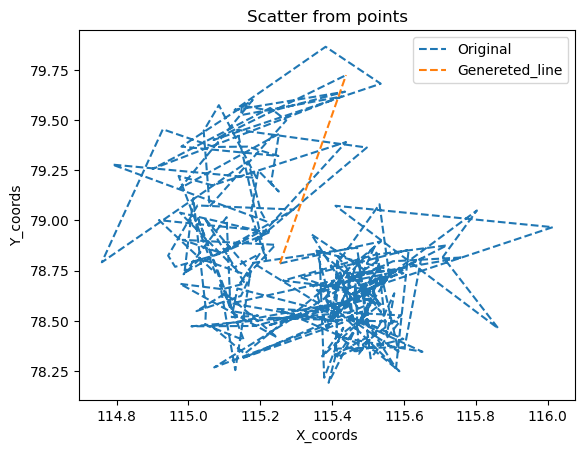

In [61]:
# Testing the generation of points:
# first_list:
x_values, y_values = zip(*track_positions_dict['Track_10'])
# Second_list:
x_2, y_2 = zip(*straight_tracks_dict['Track_10'])

# Creating a scatterL
plt.plot(x_values, y_values, linestyle= 'dashed', label = 'Original')
plt.plot(x_2, y_2, linestyle='dashed', label = 'Genereted_line')
plt.xlabel('X_coords')
plt.ylabel('Y_coords')
plt.legend()
plt.title('Scatter from points')

plt.show()